In [1]:
import pandas as pd
from pathlib import Path

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd
import numpy as np
import re
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score
from statistics import mean
from sklearn.metrics import hamming_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

from sklearn.metrics import roc_auc_score, confusion_matrix
import statistics
from sklearn.metrics import recall_score

from wordcloud import WordCloud
from collections import Counter

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/sample_submission.csv
/kaggle/input/test.csv.zip
/kaggle/input/train.csv.zip
/kaggle/input/description.md
/kaggle/input/sample_submission.csv.zip
/kaggle/input/train.csv
/kaggle/input/test.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/description.md
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv


In [3]:
train = pd.read_csv("/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip")
test = pd.read_csv("/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip")
train.head(3)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0


In [4]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train[class_names].apply(lambda x: x.value_counts())


,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,144277,157976,151122,159093,151694,158166
1,15294,1595,8449,478,7877,1405


In [5]:
train[class_names].apply(lambda x: x.value_counts(normalize=True))


,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0.904156,0.990004,0.947052,0.997004,0.950636,0.991195
1,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805


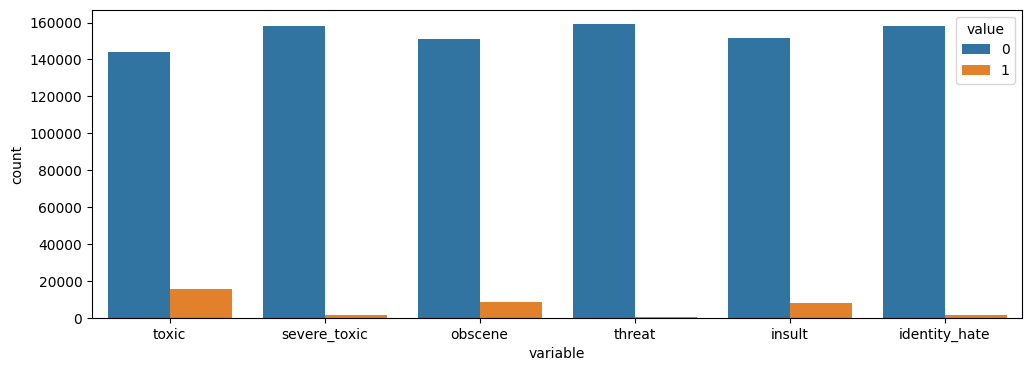

In [6]:
plt.figure(figsize=(12,4))
sns.countplot(x="variable", hue="value", data=pd.melt(train[class_names]))

plt.show()


In [7]:
toxic_df = train[train["toxic"] == 1]
toxic_df = toxic_df["comment_text"].reset_index(drop=True)

toxic_text = ""

for i in range(len(toxic_df)):
    toxic_text += " " + toxic_df[i]
    
toxic_text[:100]


' COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK Hey... what is it..\n@ | talk .\nWhat is it... an exclus'

In [8]:
tokens = re.findall(r'\w+', toxic_text)
print("Number of toxic tokens = "+"{:,}\n".format(len(tokens)))
print(tokens[:50])


Number of toxic tokens = 815,264

['COCKSUCKER', 'BEFORE', 'YOU', 'PISS', 'AROUND', 'ON', 'MY', 'WORK', 'Hey', 'what', 'is', 'it', 'talk', 'What', 'is', 'it', 'an', 'exclusive', 'group', 'of', 'some', 'WP', 'TALIBANS', 'who', 'are', 'good', 'at', 'destroying', 'self', 'appointed', 'purist', 'who', 'GANG', 'UP', 'any', 'one', 'who', 'asks', 'them', 'questions', 'abt', 'their', 'ANTI', 'SOCIAL', 'and', 'DESTRUCTIVE', 'non', 'contribution', 'at', 'WP']


In [9]:
import nltk
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english') # All English Stopwords
#stop_words = set(stopwords.words('english'))

tokens = [t.lower() for t in tokens if t.lower() not in stop_words]
print(Counter(tokens).most_common(50))


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('fuck', 9934), ('wikipedia', 3678), ('shit', 3622), ('like', 3512), ('nigger', 3300), ('fucking', 3289), ('suck', 3235), ('ass', 2939), ('u', 2866), ('go', 2865), ('hate', 2631), ('get', 2300), ('gay', 2239), ('know', 2201), ('page', 2147), ('die', 2082), ('faggot', 2017), ('fat', 1970), ('people', 1873), ('moron', 1862), ('bitch', 1785), ('hi', 1691), ('cunt', 1540), ('one', 1529), ('sucks', 1443), ('stupid', 1439), ('wiki', 1436), ('stop', 1420), ('talk', 1402), ('article', 1394), ('pig', 1355), ('jew', 1350), ('dick', 1303), ('user', 1264), ('penis', 1239), ('think', 1236), ('want', 1220), ('bullshit', 1139), ('life', 1089), ('block', 1089), ('time', 1064), ('asshole', 1042), ('wanker', 1035), ('dont', 1031), ('would', 1021), ('fag', 1012), ('even', 1007), ('bark', 1001), ('balls', 999), ('right', 959)]


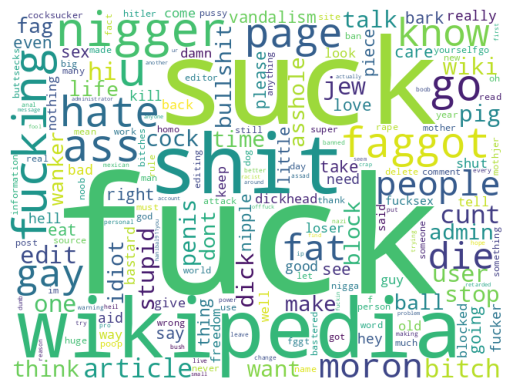

In [10]:
text_wordcloud = " ".join(tokens)
cloud = WordCloud(background_color="white", width=640, height=480, collocations = False).generate(text_wordcloud)

plt.imshow(cloud)
plt.axis("off")
plt.show()


In [11]:
s_toxic_df = train[train["severe_toxic"] == 1]
s_toxic_df = s_toxic_df["comment_text"].reset_index(drop=True)
s_toxic_text = ""
for i in range(len(toxic_df)):
    s_toxic_text += " " + toxic_df[i]


some_frac_total_text = toxic_text + s_toxic_text 
print("Characters = "+"{:,}".format(len(some_frac_total_text)))
print("Words = "+"{:,}".format(len(some_frac_total_text.split())))
print("Unique words from first two = "+"{:,}".format(len(set(some_frac_total_text.split()))))


Characters = 9,061,574
Words = 1,568,852
Unique words from first two = 73,682


In [12]:
train_text = train['comment_text']
test_text = test['comment_text']
all_text = pd.concat([train_text, test_text])
all_text.head()


0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object

In [13]:
%%time
# To simplify our tasks, we will use TfidfVectorizer which is equivalent to CountVectorizer 
# followed by TfidfTransformer to convert a collection of text comments to a matrix of TF-IDF 
# features.
# learn vocabulary and idf from all the text data 
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=10000)

word_vectorizer.fit(all_text)


CPU times: user 8.1 s, sys: 143 ms, total: 8.25 s
Wall time: 8.23 s


TfidfVectorizer(max_features=10000, stop_words='english',
                strip_accents='unicode', sublinear_tf=True,
                token_pattern='\\w{1,}')

In [14]:
%%time
# transform words to document-term matrix
train_features = word_vectorizer.transform(train_text)
test_features = word_vectorizer.transform(test_text)


CPU times: user 7.94 s, sys: 30.4 ms, total: 7.97 s
Wall time: 7.91 s


In [15]:
%%time
scores = []
submission = pd.DataFrame.from_dict({'id': test['id']})
for class_name in class_names: # We have six of these
    train_target = train[class_name]
    classifier = LogisticRegression(C=1, solver='sag')

    cv_score = np.mean(cross_val_score(classifier, train_features, train_target, cv=3, scoring='roc_auc'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(train_features, train_target)
    submission[class_name] = classifier.predict_proba(test_features)[:, 1]
    

print('Total CV score is {}'.format(np.mean(scores)))


CV score for class toxic is 0.9682331061437695
CV score for class severe_toxic is 0.9858610574895218
CV score for class obscene is 0.9845138024194101
CV score for class threat is 0.9823523324012413
CV score for class insult is 0.9753586158624573
CV score for class identity_hate is 0.974276001961349
Total CV score is 0.9784324860462915
CPU times: user 15.8 s, sys: 19.7 ms, total: 15.9 s
Wall time: 15.7 s


In [16]:
train.drop('id', axis=1, inplace=True)

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
bigX = train.drop(labels,axis=1)
bigX = bigX.to_numpy().reshape(-1,) # It has only comment_text
bigy = train[labels].to_numpy()
bigX.shape, bigy.shape


((159571,), (159571, 6))

In [17]:
from sklearn.model_selection import train_test_split
X_train_dev, X_test, y_train_dev, y_test = train_test_split(bigX, bigy,
                                                    test_size=0.2)

X_train, X_val, y_train, y_val = train_test_split(X_train_dev, y_train_dev,
                                                    test_size=0.2)


In [18]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import pad_sequences
max_words = 2000
max_len = 200
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(bigX)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix_train = pad_sequences(sequences,maxlen=max_len)
sequences = tok.texts_to_sequences(X_test)
sequences_matrix_test = pad_sequences(sequences,maxlen=max_len)
sequences = tok.texts_to_sequences(X_val)
sequences_matrix_val = pad_sequences(sequences,maxlen=max_len)
sequences = tok.texts_to_sequences(bigX)
sequences_matrix_big = pad_sequences(sequences,maxlen=max_len)


2025-08-18 14:06:33.190826: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755525993.199849       8 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755525993.202591       8 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-18 14:06:33.214347: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


ModuleNotFoundError: No module named 'keras.preprocessing.text'

In [19]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Embedding(max_words,50,input_length=max_len, input_shape=[max_len]))
model.add(layers.LSTM(64, dropout=0.2))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(6, activation='sigmoid'))

model.summary()


NameError: name 'max_words' is not defined

In [20]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])


2025-08-18 14:06:38.881483: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [21]:
history = model.fit(sequences_matrix_train,
                    y_train,
                    epochs=75,
                    batch_size=512,
                    validation_data=(sequences_matrix_val, y_val))


NameError: name 'sequences_matrix_train' is not defined

In [22]:
history_df = pd.DataFrame(history.history)
history_df.head()


NameError: name 'history' is not defined

In [23]:
model.evaluate(sequences_matrix_test, y_test)


NameError: name 'sequences_matrix_test' is not defined

In [24]:
id_col = test['id']
test = test.drop('id', axis=1).to_numpy().reshape(-1,)
sequences = tok.texts_to_sequences(test)
sequences_matrix_test_final = pad_sequences(sequences,maxlen=max_len)
y_pred = model.predict(sequences_matrix_test_final)


NameError: name 'tok' is not defined

In [25]:
prediction_df = pd.DataFrame()
prediction_df['id'] = id_col
prediction_df[labels] = y_pred
prediction_df


NameError: name 'y_pred' is not defined

In [26]:
prediction_df.to_csv('submission.csv', index=False)
